In [1]:
!pip install tensorflow==2.4.1
!pip install keras==2.4.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.3 MB 14 kB/s 
     |████████████████████████████████| 2.9 MB 51.5 MB/s 
     |████████████████████████████████| 132 kB 64.7 MB/s 
     |████████████████████████████████| 462 kB 58.4 MB/s 
     |████████████████████████████████| 3.8 MB 55.5 MB/s 
     |████████████████████████████████| 14.8 MB 55.1 MB/s 
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4848 sha256=773b80100e9782c4ed195ac0b7db0295d1004684ddf0f355fecd2f4077081f11
  Stored in directory: /root/.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68719 sha256=395432fa0534fb181397e857cea5f2255f3e79f285567c4b1ac334eee1268c29
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built term

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


# Deep Convolutional GAN (DCGAN) with MNIST

This is a follow-up on [gan_mnist.ipynb](gan_mnist.ipynb).  It uses deep convolutional networks in the generator and the discriminator.

In [2]:
import numpy as np
from scipy.io import loadmat
import keras
import keras.backend as K
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST Dataset

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


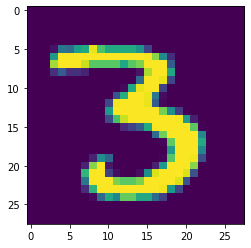

In [4]:
plt.imshow(X_train[12])

We only use the images not the categorical labels.

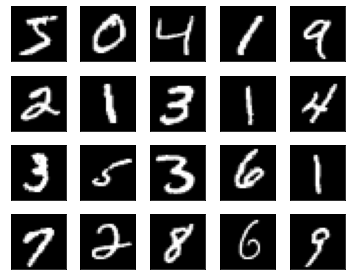

In [5]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Preprocessing and Deprocessing

As usual, we need preprocessing and later deprocessing of the images.  

As we will see later on, the generator is using `tanh` activation, for which we need to preprocess the image data into the range between -1 and 1.

In [6]:
def preprocess(x):    
    x = x.reshape(-1, 28, 28, 1) #-1 means number of examples are undefined/unknown
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x
## np.clip()
## Given an interval, values outside the interval are clipped to the interval edges.
## For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.

def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

Apply the preprocessing on the train and test images (and they are the real images as oppose to the generated images).

In [7]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

In [8]:
print("Actual X_test :", X_test.shape)
print("Actual X_train :", X_train.shape)

print("Actual X_test_pp :", X_test_real.shape)
print("Actual X_train_pp :",X_train_real.shape)
# print(X_test)


Actual X_test : (10000, 28, 28)
Actual X_train : (60000, 28, 28)
Actual X_test_pp : (10000, 28, 28, 1)
Actual X_train_pp : (60000, 28, 28, 1)


## Generator

The original DCGAN paper [[3]](#ref3) proposes the following generator network architecture.

<img src='../images/dcgan_svhn/generator.png' width='70%'>

In this notebook, I used smaller networks than what the original paper [[3]](#ref3) uses as our image size is 28x28 and it has only 1 channel.

The generator takes a latent sample of 100 random numbers and generates a 28x28 image with 1 channel.

The first layer accepts 784 data points just like [gan_mnist.ipynb](gan_mnist.ipynb).  Then, it reshapes the data into 7x7 with 16 filters.  Afterwards, two transposed convolution layers will up-sample the data shape into 28x28.


In [9]:
def make_generator(input_size, leaky_alpha):
    # generates images in (28,28,1)
    
    return Sequential([
        # FC 1: 7,7,16
        Dense(784, input_shape=(input_size,)),
        Reshape(target_shape=(7, 7, 16)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 1: 14,14,32
        Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'), 
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 2: 28,28,1
        Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'),
        Activation('tanh')
    ])

## Discriminator


The discriminator is a classifier to tell if the input image is real or fake.  

It is a convolutional neural network that takes a 28x28 image with 1 channel.  The values in the image is expected to be between -1 and 1.

The activation of the output layer is `sigmoid` and the discriminator outputs a probability of the image being real.

In [gan_mnist.ipynb](gan_mnist.ipynb), I used a fully connected layer with 784 (=28x28) neurons.  To make this discriminator comparable, I use the same number of neurons in the last fully connected hidden layer, and then added convolution layers beforehands.

Note: using the decreasing number of filters may be a bit unusual but I did this to make the discriminator network and the generator network to have same kind of increase in the number of convolutional network neurons (hopefully keeping their power in balance).

In [10]:
def make_discriminator(leaky_alpha):
    # classifies images in (28,28,1)
    return Sequential([        
        # Conv 1: 14,14,32
        Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=(28,28,1)),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 2: 7,7,16
        Conv2D(16, kernel_size=5, strides=2, padding='same'),   
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # FC 1
        Flatten(),
        Dense(784),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Output
        Dense(1),
        Activation('sigmoid')        
    ])

### About Batch Normalization

As for the batch normalization, it was applied to most of the layers but not all.  The below is a quote from the original DCGAN paper [[3]](#ref3).

> Directly applying batchnorm to all layers, however, resulted in sample oscillation and model instability. This was avoided by not applying batchnorm to the generator output layer and the discriminator input layer.


## DCGAN

We connect the generator and the discriminator to make a DCGAN.

The input to the DCGAN is a latent sample.  The generator inside DCGAN produces an image which is fed into the discriminator inside the DCGAN.  So, the output of DCGAN is the probability of the generated image being real.

In [11]:
# beta_1 is the exponential decay rate for the 1st moment estimates in Adam optimizer
def make_DCGAN(sample_size, 
               g_learning_rate,
               g_beta_1,
               d_learning_rate,
               d_beta_1,
               leaky_alpha):
    # clear first
    K.clear_session()
    
    # generator
    generator = make_generator(sample_size, leaky_alpha)

    # discriminator
    discriminator = make_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    return gan, generator, discriminator

## Training DCGAN

The below is a function to generate latent samples.

In [12]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

The below is a function to set the discriminator to trainable or non-trainable.

In [13]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

The below is a function to create a batch of labels.

In [14]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

The below is to show the losses.

In [15]:
def show_results(losses):
    labels = ['Classifier', 'Discriminator', 'Generator']
    losses = np.array(losses)    
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()    

The below is to show the generated images.

In [16]:
def show_images(generated_images):
    n_images = len(generated_images)
    rows = 4
    cols = n_images//rows
    
    plt.figure(figsize=(cols, rows))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show() 

The training DCGAN is essentially the same as training a simple GAN in [gan_mnist.ipynb](gan_mnist.ipynb).

* set the discriminator trainable
* train the discriminator with real images with the label smoothing   (labels=1-smooth)
* train the discriminator with fake images generated by the generator (labels=0)
* set the discriminator non-trainable
* train the DCGAN with generated images (labels=1)

We repeat this process many times until the discriminator loss and the generator loss stabilizes.

In [17]:
def train(
    g_learning_rate,   # learning rate for the generator
    g_beta_1,          # the exponential decay rate for the 1st moment estimates in Adam optimizer
    d_learning_rate,   # learning rate for the discriminator
    d_beta_1,          # the exponential decay rate for the 1st moment estimates in Adam optimizer
    leaky_alpha,
    smooth=0.1,        # label smoothing
    sample_size=100,   # latent sample size (i.e. 100 random numbers)
    epochs=100,
    batch_size=128,    # train batch size
    eval_size=16,      # evaluate size
    show_details=True):
    
    # labels for the batch size and the test size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)

    # create a GAN, a generator and a discriminator
    gan, generator, discriminator = make_DCGAN(
        sample_size, 
        g_learning_rate, 
        g_beta_1,
        d_learning_rate,
        d_beta_1,
        leaky_alpha)

    losses = []
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
            # real MNIST digit images
            X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]

            # latent samples and the generated digit images
            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)

            # train the discriminator to detect real and fake images
            make_trainable(discriminator, True)
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)

            # train the generator via GAN
            make_trainable(discriminator, False)
            gan.train_on_batch(latent_samples, y_train_real)

        # evaluate
        X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)

        d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!

        losses.append((d_loss, g_loss))

        print("Epoch:{:>3}/{} Discriminator Loss:{:>7.4f} Generator Loss:{:>7.4f}".format(
            e+1, epochs, d_loss, g_loss))
        
        if show_details and (e+1)%10==0:
            show_images(X_eval_fake)
    if show_details:
        show_results(losses)
    return generator

In [19]:
# x = train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.01);

It's definitely much better than the results from the simple GAN MNIST model in [gan_mnist.ipynb](gan_mnist.ipynb).

Epoch:  1/100 Discriminator Loss:16.0194 Generator Loss: 0.7588
Epoch:  2/100 Discriminator Loss: 4.9178 Generator Loss: 0.0167
Epoch:  3/100 Discriminator Loss: 1.4349 Generator Loss: 1.5817
Epoch:  4/100 Discriminator Loss:16.6798 Generator Loss:15.1206
Epoch:  5/100 Discriminator Loss:10.2941 Generator Loss: 9.8974
Epoch:  6/100 Discriminator Loss: 2.1078 Generator Loss: 2.8354
Epoch:  7/100 Discriminator Loss: 5.2351 Generator Loss: 4.8643
Epoch:  8/100 Discriminator Loss: 9.0939 Generator Loss: 9.5570
Epoch:  9/100 Discriminator Loss: 7.5135 Generator Loss: 8.9792
Epoch: 10/100 Discriminator Loss: 7.2191 Generator Loss: 8.3245


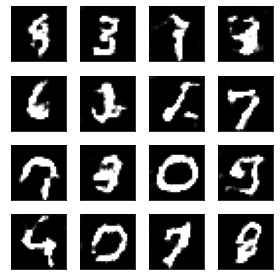

Epoch: 11/100 Discriminator Loss: 6.7046 Generator Loss: 7.8784
Epoch: 12/100 Discriminator Loss: 2.3191 Generator Loss: 3.4691
Epoch: 13/100 Discriminator Loss: 2.2872 Generator Loss: 1.2705
Epoch: 14/100 Discriminator Loss: 1.8934 Generator Loss: 2.5318
Epoch: 15/100 Discriminator Loss: 3.0662 Generator Loss: 0.3462
Epoch: 16/100 Discriminator Loss: 5.9888 Generator Loss: 4.6813
Epoch: 17/100 Discriminator Loss:10.9872 Generator Loss:11.1274
Epoch: 18/100 Discriminator Loss:18.6071 Generator Loss:17.8980
Epoch: 19/100 Discriminator Loss:32.9546 Generator Loss:30.8283
Epoch: 20/100 Discriminator Loss: 6.3391 Generator Loss: 4.4522


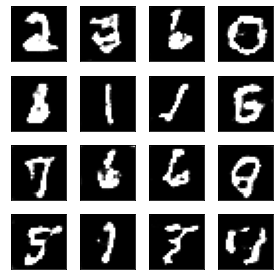

Epoch: 21/100 Discriminator Loss: 5.5487 Generator Loss: 4.9092
Epoch: 22/100 Discriminator Loss: 5.5006 Generator Loss: 0.4162
Epoch: 23/100 Discriminator Loss: 2.7212 Generator Loss: 0.2269
Epoch: 24/100 Discriminator Loss: 5.5017 Generator Loss: 0.0252
Epoch: 25/100 Discriminator Loss: 4.9023 Generator Loss: 0.2497
Epoch: 26/100 Discriminator Loss: 4.3196 Generator Loss: 2.9078
Epoch: 27/100 Discriminator Loss: 5.1932 Generator Loss: 0.3157
Epoch: 28/100 Discriminator Loss: 5.9898 Generator Loss: 0.1800
Epoch: 29/100 Discriminator Loss: 8.4650 Generator Loss: 0.0291
Epoch: 30/100 Discriminator Loss: 7.4022 Generator Loss: 5.1382


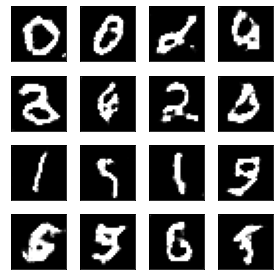

Epoch: 31/100 Discriminator Loss: 3.9118 Generator Loss: 2.8389
Epoch: 32/100 Discriminator Loss: 3.6623 Generator Loss: 2.0769
Epoch: 33/100 Discriminator Loss: 6.0105 Generator Loss: 2.1048
Epoch: 34/100 Discriminator Loss: 5.3882 Generator Loss: 0.8838
Epoch: 35/100 Discriminator Loss: 7.3633 Generator Loss: 6.6184
Epoch: 36/100 Discriminator Loss: 3.0561 Generator Loss: 1.6759
Epoch: 37/100 Discriminator Loss: 4.1583 Generator Loss: 3.6775
Epoch: 38/100 Discriminator Loss:10.3138 Generator Loss: 9.8118
Epoch: 39/100 Discriminator Loss: 4.4292 Generator Loss: 1.0134
Epoch: 40/100 Discriminator Loss: 5.0187 Generator Loss: 4.0573


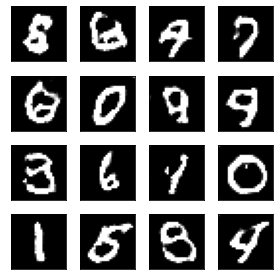

In [ ]:
train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.2);

I used leaky_relu=0.2 for the above experiment.  The losses oscillates more.  The generated images look as good.

## References

<a id="ref1"></a>
### [1] MNIST dataset
 
Yann LeCun
 
http://yann.lecun.com/exdb/mnist/

<a id="ref2"></a>
### [2] Deep Convolutional GANs

Udacity

https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb

<a id="ref3"></a>
### [3] Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

Alec Radford & Luke Metz (indico Research), Soumith Chintala (Facebook AI Research)

https://arxiv.org/pdf/1511.06434.pdf